In [1]:
# Pyspark in Jupyter : findSpark package to make a Spark Context available in your code
import findspark
findspark.init("/usr/hdp/current/spark2-client")

In [2]:
# Spark Context Initialization 

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark.sql.types import *
import datetime
from itertools import chain
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import lit ,row_number,col, monotonically_increasing_id, when

sc = SparkContext()
sqlc = SQLContext(sc)


In [3]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px

In [4]:
# Visualization Tools 
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.gridspec import GridSpec
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)
sns.set()
style.use('fivethirtyeight')

In [5]:
# Define Constants 
day = [(2,116),(81,1445) , (217,2855), (3634,4410), (5156,5885), (6554,7189), (7833,8476), (9078,9624)] 
night = [(117,810), (1446,2169), (2856,3633), (4411,5155), (5886,6553), (7190,7832), (8477,9077)]
dry = [(2,6148), (7462,9624)]
rainy = [(6149,7461)] 
#proportionality constant and taken as; 1.8615
proConstant = 1.8615
standardTemp = 23.17
standardPH = 7.0
standardTurb = 198
headers = ['Temperature','pH','Turbidity','Quality']
variables = ['Humidity','Night']
colors = ['lightcoral','deepskyblue',
          'orchid',    'tomato',
          'teal',      'darkcyan',
          'limegreen', 'darkorange']

In [6]:
# Calculating correlation between variables 
def cal_corr(tempData):
    corrData = tempData.drop('Night') # .drop('Humidity')
    vectorCol = "corrFeatures"
    assemCorr= VectorAssembler(inputCols=corrData.columns, outputCol=vectorCol)
    vectorDF = assemCorr.transform(corrData).select(vectorCol)
    corrMatrix = Correlation.corr(vectorDF, vectorCol)
    corrNP = corrMatrix.collect()[0][corrMatrix.columns[0]].toArray()
    headers = ['Temperature','pH','Turbidity','Quality','Humidity']
    corrNP = pd.DataFrame(corrNP, columns=headers, index=headers)
    return corrNP

In [7]:
# Distribution Charts 
def distribution_plot(column, title):

    fig = plt.figure(figsize=(17, 7))
    grid = GridSpec(nrows=2, ncols=1, figure=fig)
    color = np.random.choice(colors, 1)[0]

    ax0 = fig.add_subplot(grid[0, :])
    ax0.set_title(f'Histogram and BoxPlot of {title}')
    sns.histplot(column, ax=ax0, color=color,kde=True)

    ax1 = fig.add_subplot(grid[1, :])
    plt.axis('off')
    sns.boxplot(x=column, ax=ax1, color=color)

In [8]:
# Time series plot 
def timeseries_plot(rawData,variable):
    color = np.random.choice(colors, 1)[0]
    try:
        timePlotData = rawData.select('Date_Time',variable).toPandas()
    except:
        timePlotData = rawData
    plt.figure(figsize = (15,8))
    sns.lineplot(x = 'Date_Time', y = variable , data = timePlotData, color=color)

In [9]:
# calculating distinct count for each columns 
def distinct_count(cleandData):
    cleandData.select('Temperature').distinct().count()
    counts ={}
    for head in headers:
        if head == 'Quality':
            continue
        counts[head] = cleandData.select(head).distinct().count()
    return counts

In [10]:
# Adding Humidity:Dry=0/Rainy=1, Time: Day=0/Night=1, Quality Columns to raw data
def add_new_columns(rawData):
    rawData = rawData.withColumn("Humidity", lit(0))
    rawData = rawData.withColumn("Night", lit(0))
    rawData = rawData.withColumn("index", monotonically_increasing_id()+2)
    for row in night:
        rawData = rawData.withColumn("Night", when(rawData.index.between(int(row[0]),int(row[1])),lit(1))\
                                     .otherwise(rawData.Night))
    for row in rainy:
        rawData = rawData.withColumn("Humidity", when(rawData.index.between(int(row[0]),int(row[1])),lit(1))\
                                     .otherwise(rawData.Humidity))
    return rawData
    

In [11]:
# Row based processing using UDF function at pyspark  
def cal_quality(Temp,PH,Trub,sTemp,sPH,sTurb):
    quality = Temp*(proConstant/sTemp) + PH*(proConstant/sPH) + Trub*(proConstant/sTurb)
    return quality

In [12]:
# Calculating water quality sum(wi*value), wi=I/Si
def cal_water_quality_index(rawData):
    rawData = rawData.withColumn("sTemp", lit(standardTemp))
    rawData = rawData.withColumn("sPH", lit(standardPH))
    rawData = rawData.withColumn("sTurb", lit(standardTurb))
    qualityUdf = f.udf(cal_quality, FloatType())
    rawData=rawData.withColumn('Quality', qualityUdf(rawData.Temperature,rawData.pH,rawData.Turbidity,rawData.sTemp,rawData.sPH,rawData.sTurb))

    rawData = rawData.drop('index','sTemp','sPH','sTurb')
    return rawData

In [13]:
# Investigating the impact of weather or time conditions on variable 
def cal_weather_impact(tempData, variable):
    aggDF =tempData.groupby(variable).agg(f.mean(tempData.Temperature).alias('meanTemperature'),\
                                                             f.mean(tempData.pH).alias('meanpH'),\
                                                             f.mean(tempData.Turbidity).alias('meanTurbidity'),\
                                                             f.mean(tempData.Quality).alias('meanQuality'))
    return aggDF

In [14]:
# Preprocessing Steps
def preprocessing (rawData):
    # rename colname Temperature (°C) to Temperature 
    rawData = rawData.withColumnRenamed(rawData.columns[0], 'Date_Time')
    rawData = rawData.withColumnRenamed(rawData.columns[1], 'Temperature')
    rawData = rawData.withColumnRenamed(rawData.columns[3], 'Turbidity')
    # Adding Humidity:Dry=0/Rainy=1, Time: Day=0/Night=1, Quality Columns to raw data
    rawData = add_new_columns(rawData)
    rawData = cal_water_quality_index(rawData)
    return rawData
    
    

In [15]:
# Data Downsampleing per minutes
def downsample(rawData,minutes):
    resampledData = rawData.select(rawData.columns[:7]).toPandas()
    resampledData = resampledData.set_index('Date_Time')
    resampledData = resampledData.resample(str(minutes)+'T').mean()
    resampledData['Humidity'] = resampledData['Humidity'].fillna(0).round().astype(int)
    resampledData['Night'] = resampledData['Night'].fillna(0).round().astype(int)
    return resampledData


In [16]:
# Checking for trend, and seasonality 
def Checking_trend_seasonality(rawData,variable):
    decomData = rawData.select(rawData.columns[:7]).toPandas()
    decomData = decomData.set_index('Date_Time')
    res= seasonal_decompose(decomData[variable], model='additive',extrapolate_trend='freq', period=int(len(decomData['Turbidity'])/4))
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,24))
    ax1.set_ylabel(variable)
    ax2.set_ylabel('Ternd')
    ax3.set_ylabel('Seasonality')
    ax4.set_ylabel('Residual')
    decomData[variable].plot(ax=ax1)
    res.trend.plot(ax=ax2)
    res.resid.plot(ax=ax3)
    res.seasonal.plot(ax=ax4) 

In [17]:
# Reading Raw Data file from HDFS 
# Please change dataPath with your directory path
dataPath = 'hdfs://node1.sepahtan:8020/data/'
dataPathSens30 = dataPath + "Sensor_data_for_30_cm.csv"
dataPathSens60 = dataPath + "Sensor_data_for_60_cm.csv"
rawDataSens30= sqlc.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(dataPathSens30)
rawDataSens60= sqlc.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(dataPathSens60)


In [18]:
# Preprocessing Steps 
rawDataSens30 = preprocessing(rawDataSens30)

# EDA without Time

,Temperature,pH,Turbidity
0,817,146,56


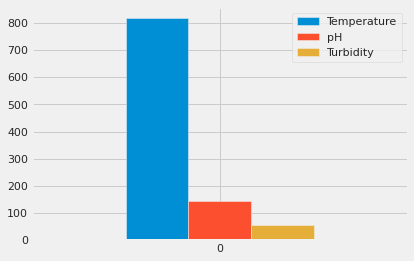

In [19]:
# Calculating Distinct Value Counts Per Each Columns
distinctCnt = distinct_count(rawDataSens30)
pd.DataFrame([distinctCnt]).plot.bar(rot=0)
pd.DataFrame([distinctCnt])


In [20]:
# Computing specified statistics for columns 
tempData  = rawDataSens30 .drop('index').drop('Date_Time')
tempData.summary().show()

+-------+------------------+-------------------+-----------------+-------------------+------------------+-------------------+
|summary|       Temperature|                 pH|        Turbidity|           Humidity|             Night|            Quality|
+-------+------------------+-------------------+-----------------+-------------------+------------------+-------------------+
|  count|              9623|               9623|             9623|               9623|              9623|               9623|
|   mean|20.004782292424537|  7.757886314039385|215.4851917281513|0.13644393640236932| 0.504312584433129|  5.696134297401533|
| stddev|2.0499856709706727|0.44360124293571496|16.17937425555526|0.34327719732491857|0.5000073817524135|0.24086073898572155|
|    min|              15.6|               6.98|              194|                  0|                 0|          5.1140623|
|    25%|             18.35|               7.38|              202|                  0|                 0|          5.5

+--------+------------------+------------------+------------------+-----------------+
|Humidity|   meanTemperature|            meanpH|     meanTurbidity|      meanQuality|
+--------+------------------+------------------+------------------+-----------------+
|       1|18.770388423457707| 7.725628332063986|238.03731911652704|5.800407765933964|
|       0|20.199819494584897|7.7629831528279665|211.92190132370638|  5.6796588384144|
+--------+------------------+------------------+------------------+-----------------+

+-----+------------------+-----------------+------------------+-----------------+
|Night|   meanTemperature|           meanpH|     meanTurbidity|      meanQuality|
+-----+------------------+-----------------+------------------+-----------------+
|    1|18.683645167937392| 7.83497836389857|215.87389243766742|5.614148232412663|
|    0| 21.34890775681344|7.679452830188668|215.08972746331236| 5.77954695429692|
+-----+------------------+-----------------+------------------+----------

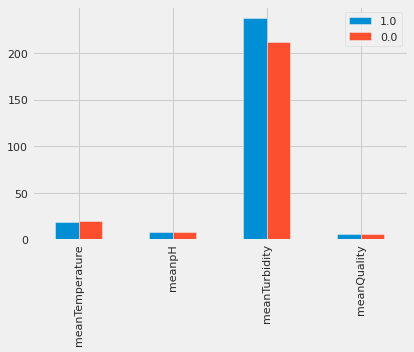

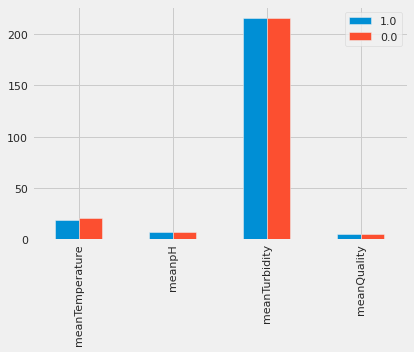

In [21]:
# Investigating the impact of weather or time conditions on variable 

for var in variables:
    aggDF = cal_weather_impact(tempData,var)
    aggDF.show()
    aggDF = aggDF.toPandas().transpose()
    aggDF =aggDF.rename(columns=aggDF.iloc[0])
    aggDF.iloc[1:].plot.bar()
    

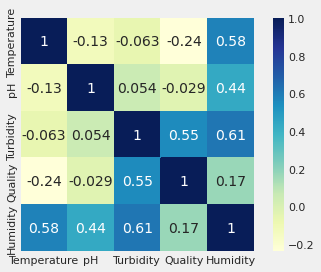

,Temperature,pH,Turbidity,Quality,Humidity
Temperature,1.000000,-0.127100,-0.063066,-0.239363,0.581711
pH,-0.127100,1.000000,0.053878,-0.028907,0.436885
Turbidity,-0.063066,0.053878,1.000000,0.554090,0.614793
Quality,-0.239363,-0.028907,0.554090,1.000000,0.172093
Humidity,0.581711,0.436885,0.614793,0.172093,1.000000


In [22]:
# Calculating correlation between variables 
corrNP = cal_corr(tempData)
sns.heatmap(corrNP, cmap='YlGnBu', annot=True, square=True)
plt.show()
corrNP

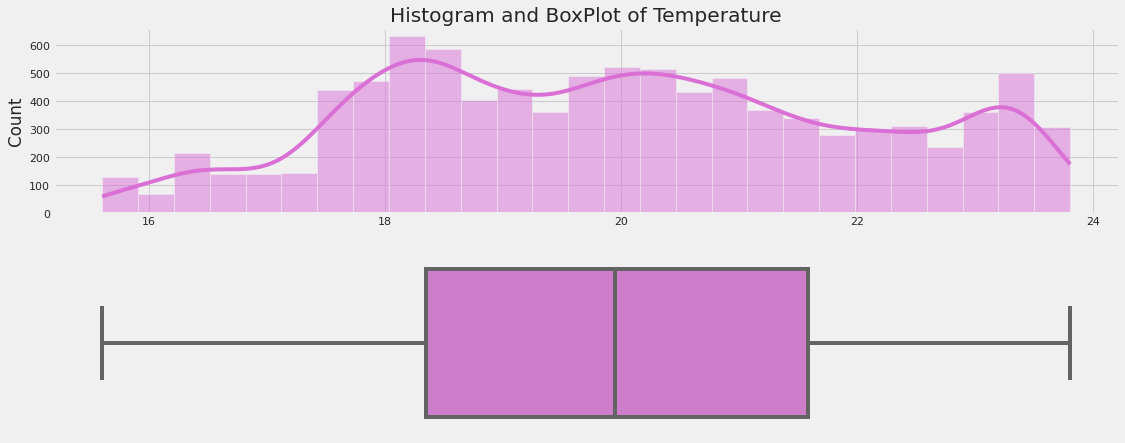

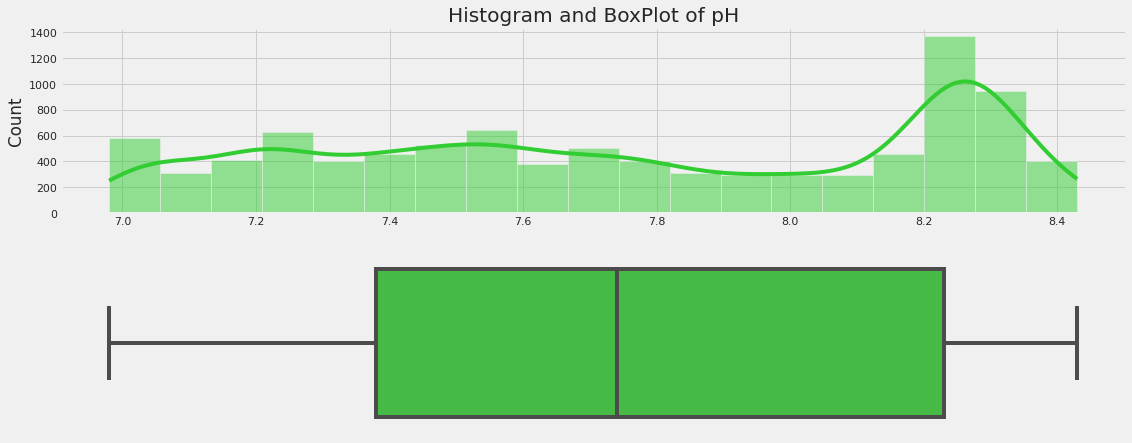

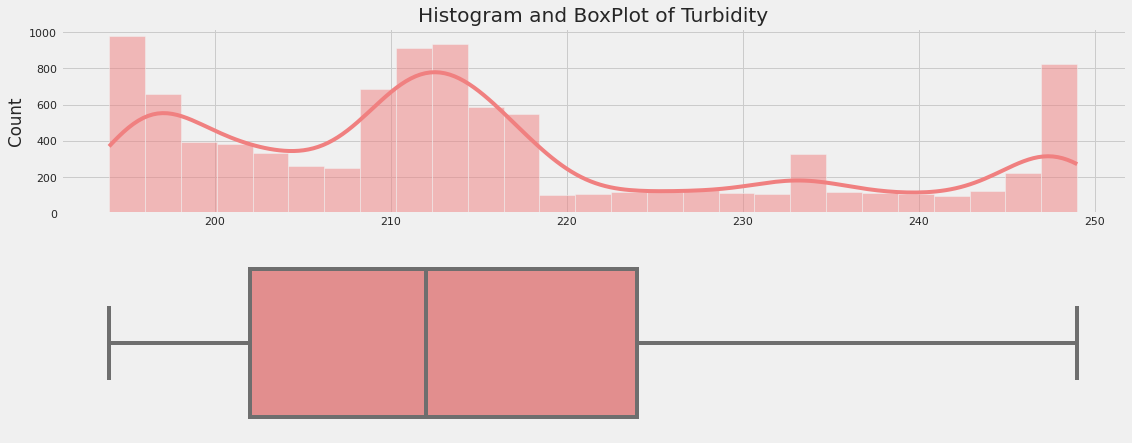

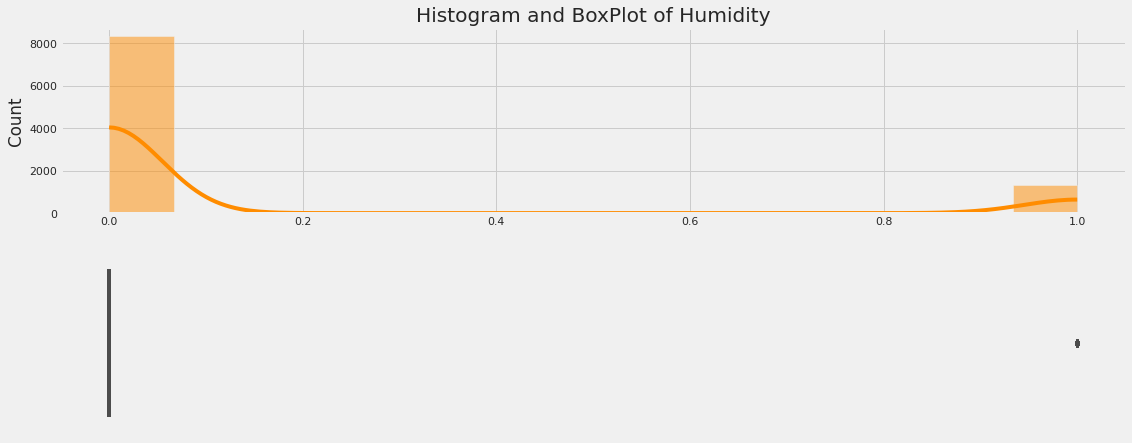

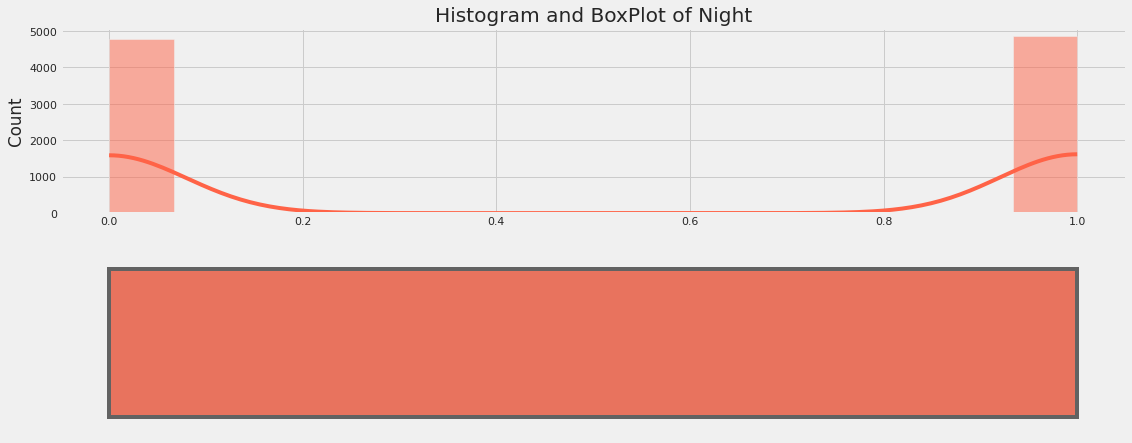

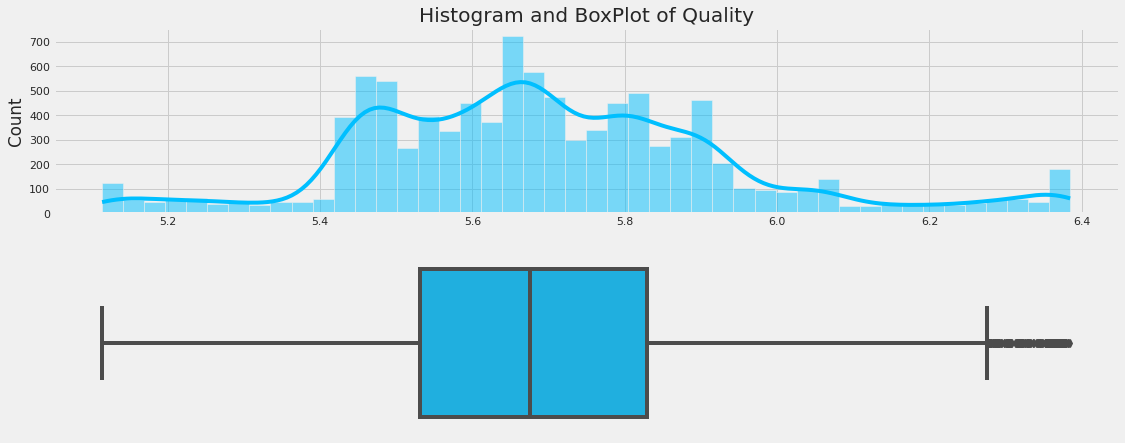

In [23]:
# Distribution Plotting 
for feature in tempData.columns:
    dataList = [data[0] for data in rawDataSens30.select(feature).collect()]
    distribution_plot(dataList, feature)    

In [24]:
# Data Downsampleing per minutes
resampledData = downsample(rawDataSens30,60)
resampledData

,Temperature,pH,Turbidity,Humidity,Night,Quality
Date_Time,,,,,,
2020-01-15 16:00:00,20.731000,7.787500,197.000000,0,0,5.588566
2020-01-15 17:00:00,20.401636,7.735636,197.000000,0,0,5.548312
2020-01-15 18:00:00,20.158302,7.720755,197.000000,0,1,5.524805
2020-01-15 19:00:00,19.658246,7.810877,196.368421,0,1,5.502658
2020-01-15 20:00:00,18.702881,8.061356,196.000000,0,1,5.489049
...,...,...,...,...,...,...
2020-01-22 12:00:00,21.508077,7.268846,211.000000,0,0,5.644693
2020-01-22 13:00:00,22.182800,7.322000,211.000000,0,0,5.713036
2020-01-22 14:00:00,22.027547,7.376226,211.000000,0,0,5.714983


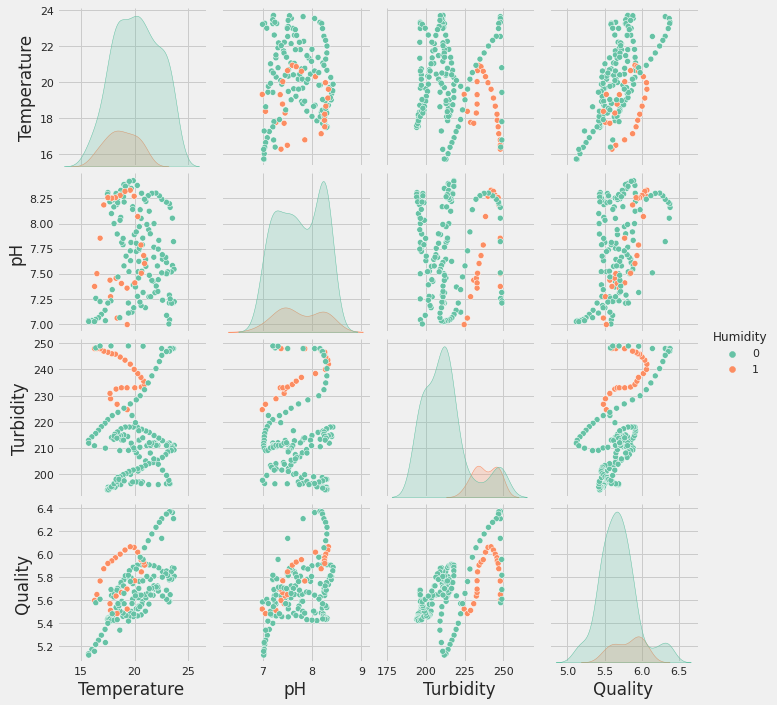

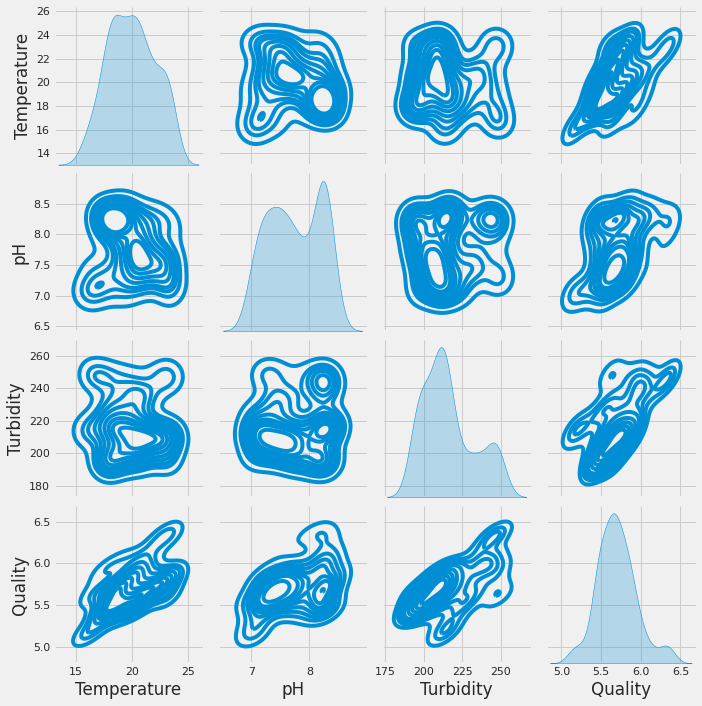

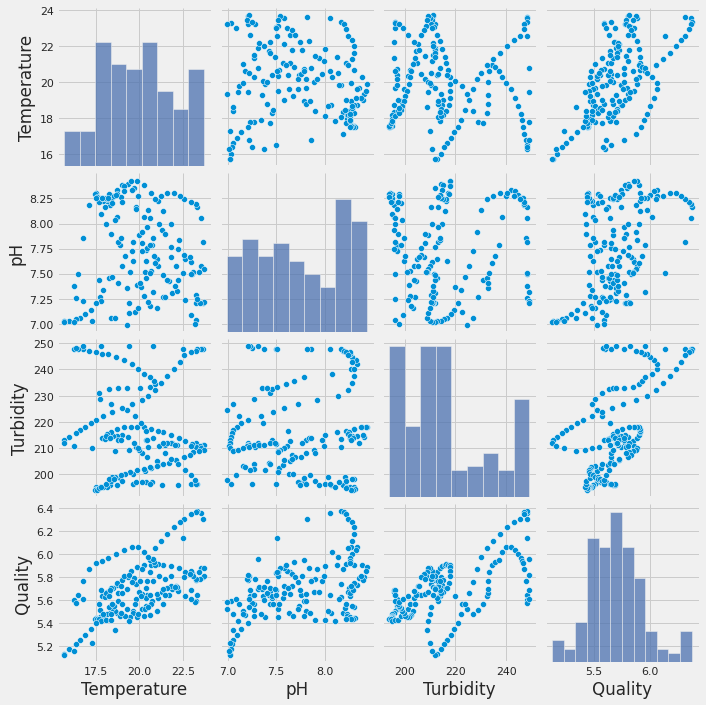

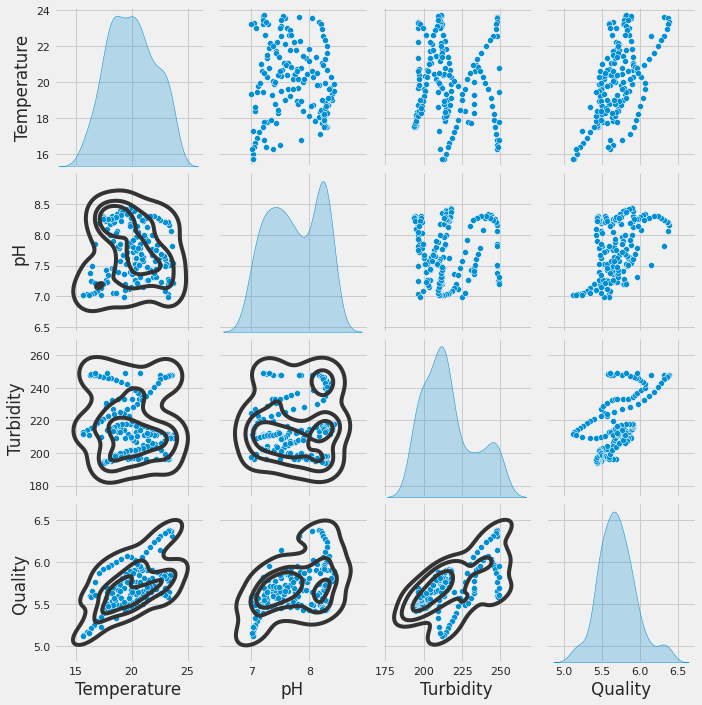

In [25]:
resampledData
sns.pairplot(resampledData.drop(['Night'],axis=1), kind='scatter', hue='Humidity', palette="Set2")
sns.pairplot(resampledData.drop(['Humidity','Night'], axis=1),kind='kde', palette="Set2")
sns.pairplot(resampledData.drop(['Humidity','Night'], axis=1),kind='scatter', palette="Set2")
g = sns.pairplot(resampledData.drop(['Humidity','Night'], axis=1), diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")


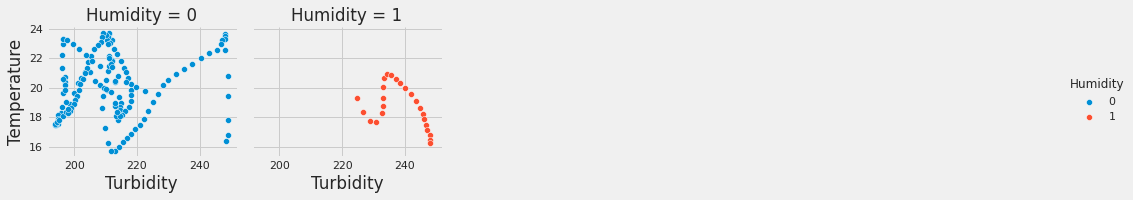

In [26]:
# 3D data Distribution
grid = sns.FacetGrid(resampledData, col = "Humidity", hue = "Humidity", col_wrap=5)
grid.map(sns.scatterplot, "Turbidity", "Temperature")
grid.add_legend()
plt.show()

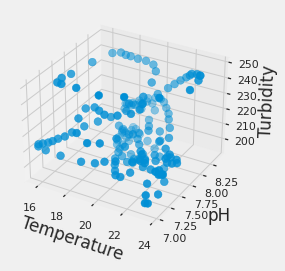

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x = resampledData['Temperature']
y = resampledData['pH']
z = resampledData['Turbidity']
ax.set_xlabel("Temperature")
ax.set_ylabel("pH")
ax.set_zlabel("Turbidity")
ax.scatter(x, y, z,s=60)
plt.show()


In [35]:
fig = px.scatter_3d(resampledData, x='Temperature', y='pH', z='Turbidity',title='Water Quality',color='Humidity',template = 'xgridoff')#, symbol='species')
fig.show()
fig = px.scatter_3d(resampledData, x='Temperature', y='pH', z='Turbidity',title='Water Quality',color='Night')#, symbol='species')
fig.show()

# # EDA with Time

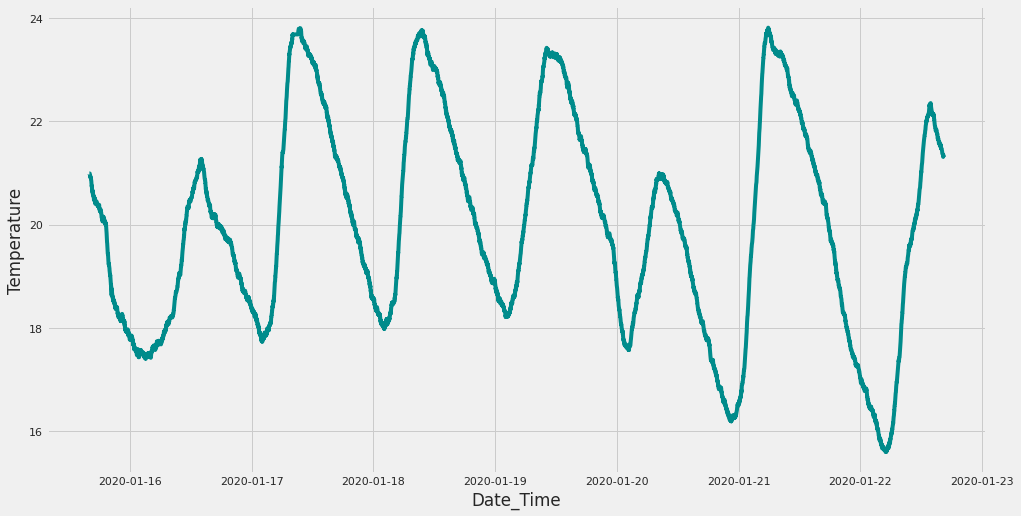

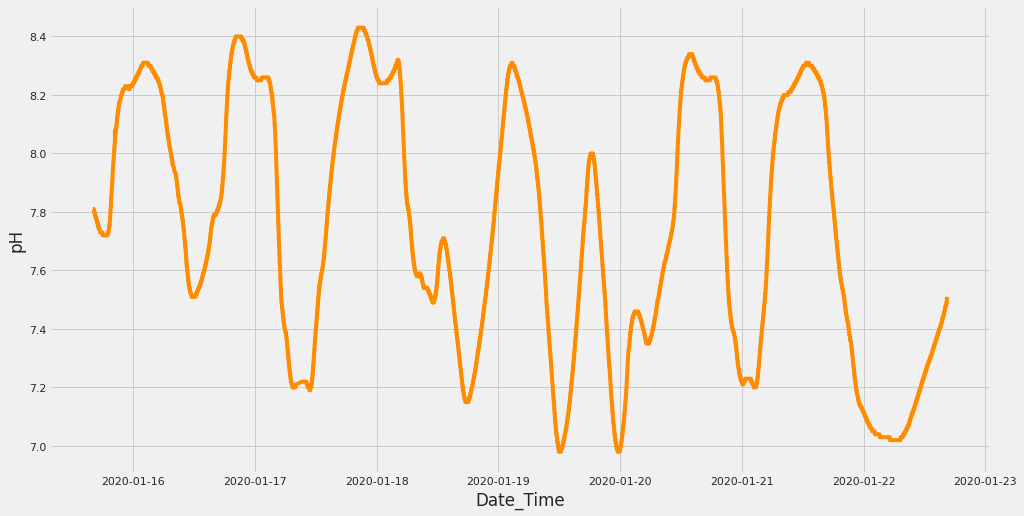

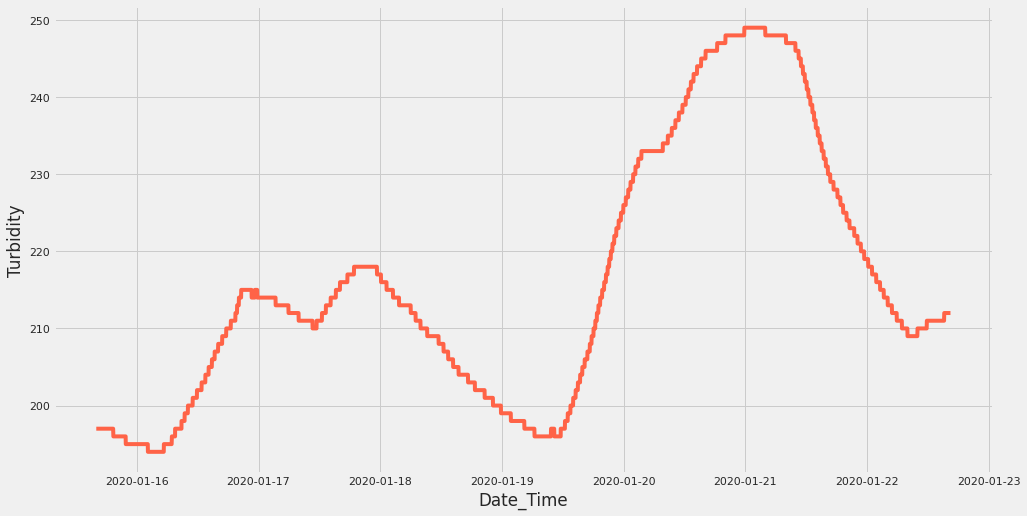

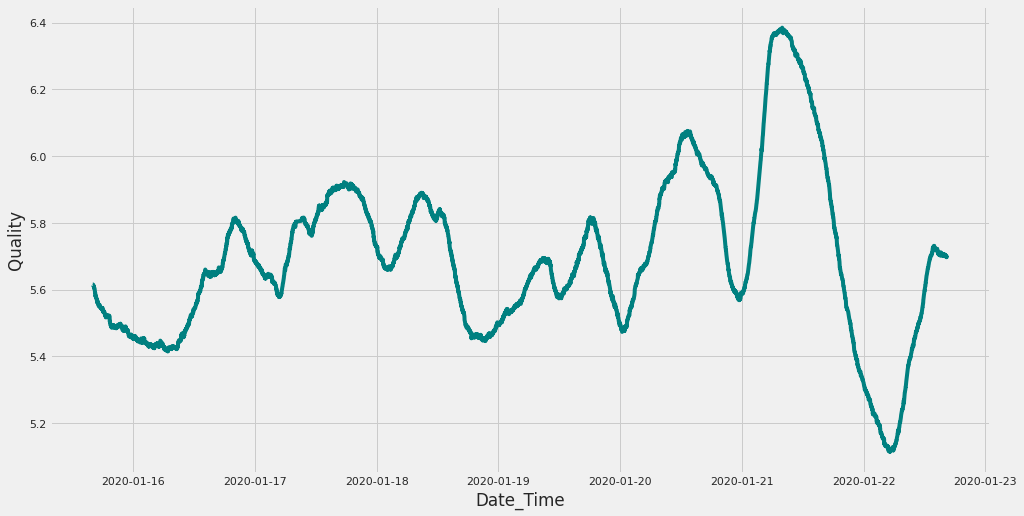

In [36]:
# Time series per minutes 
for head in headers: 
    timeseries_plot(rawDataSens30,head)

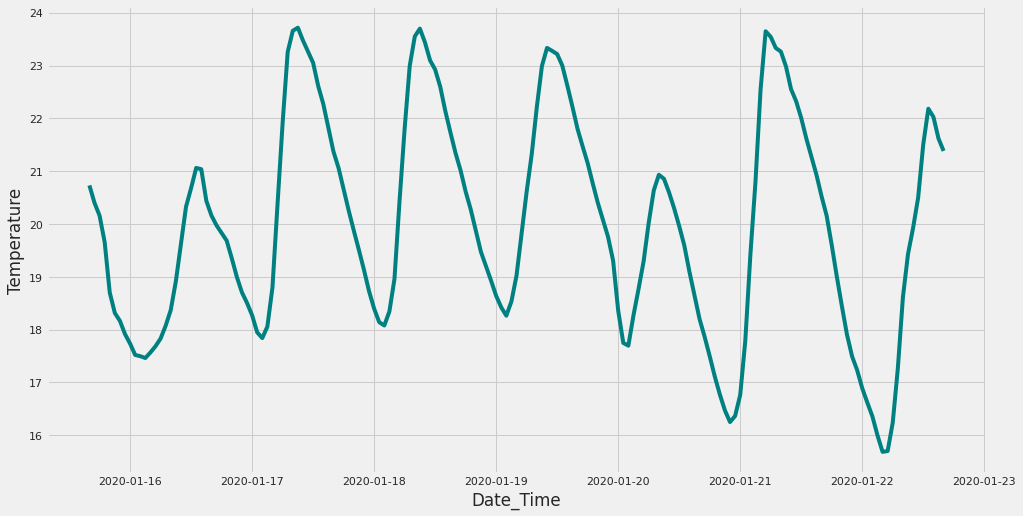

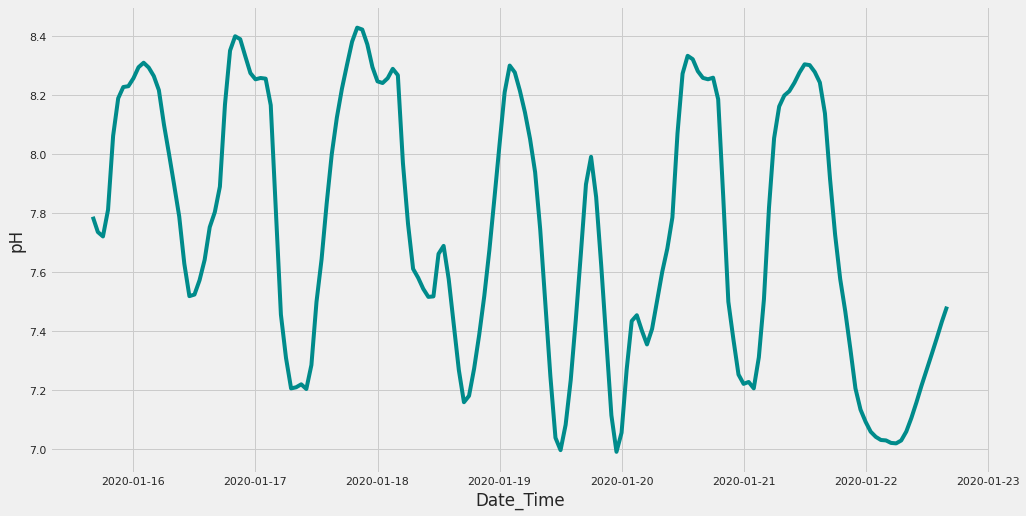

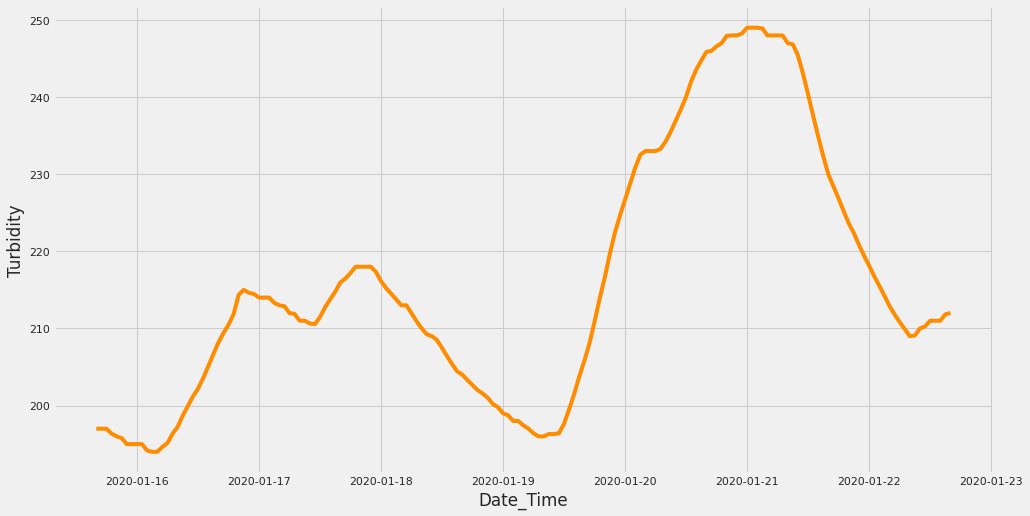

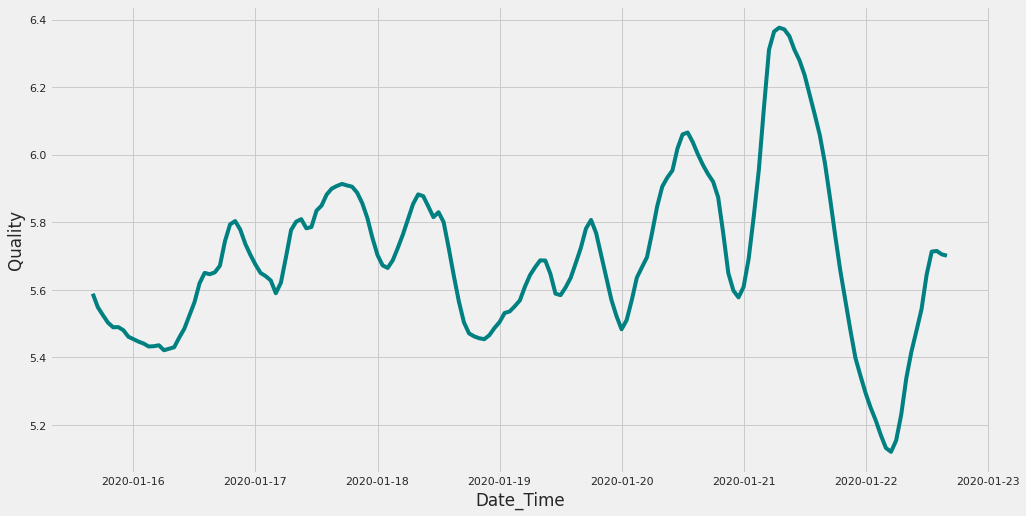

In [37]:
# Time series per houres 
for head in headers: 
    timeseries_plot(resampledData,head)


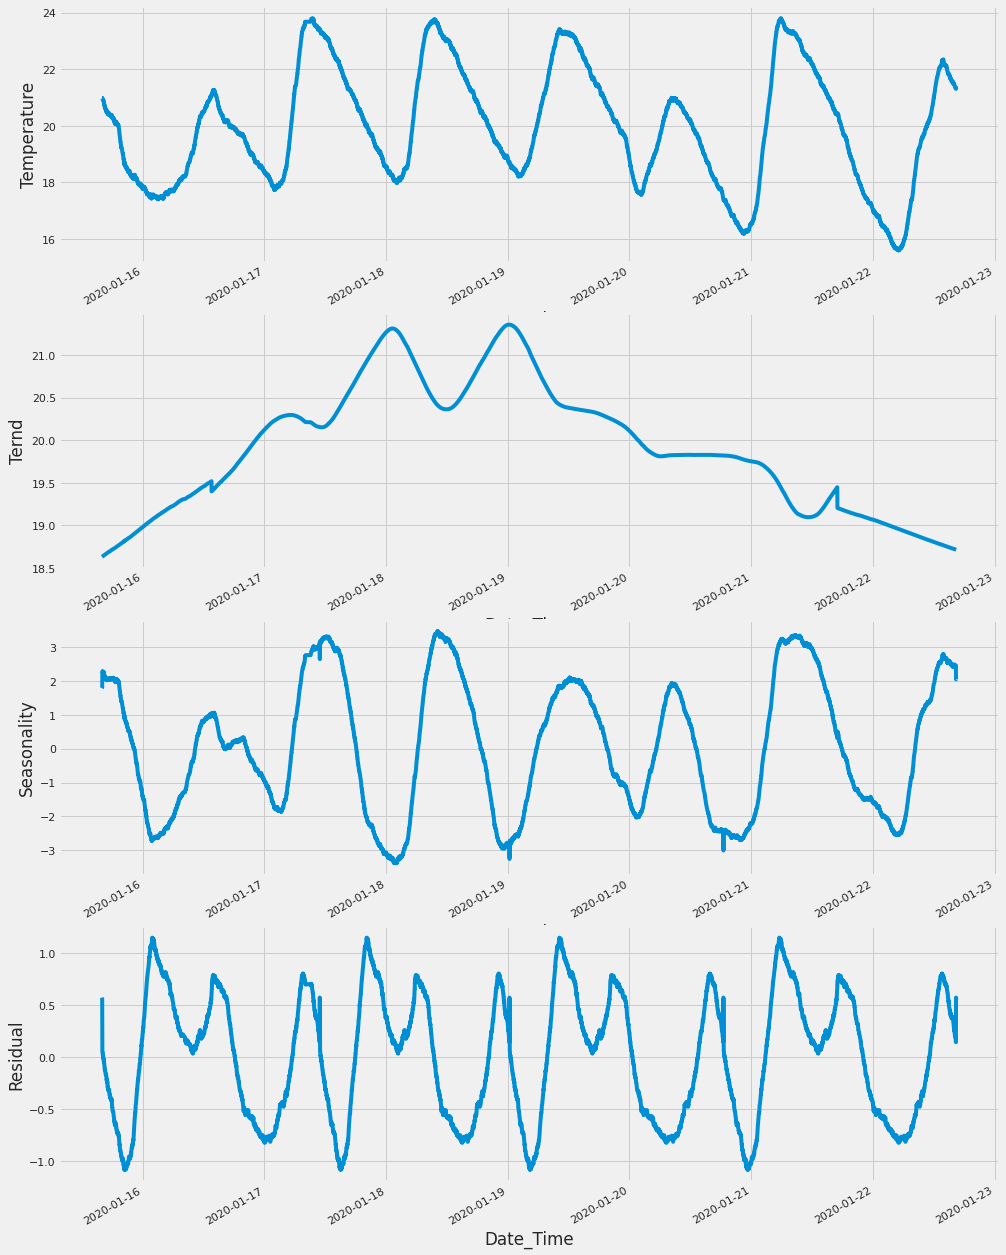

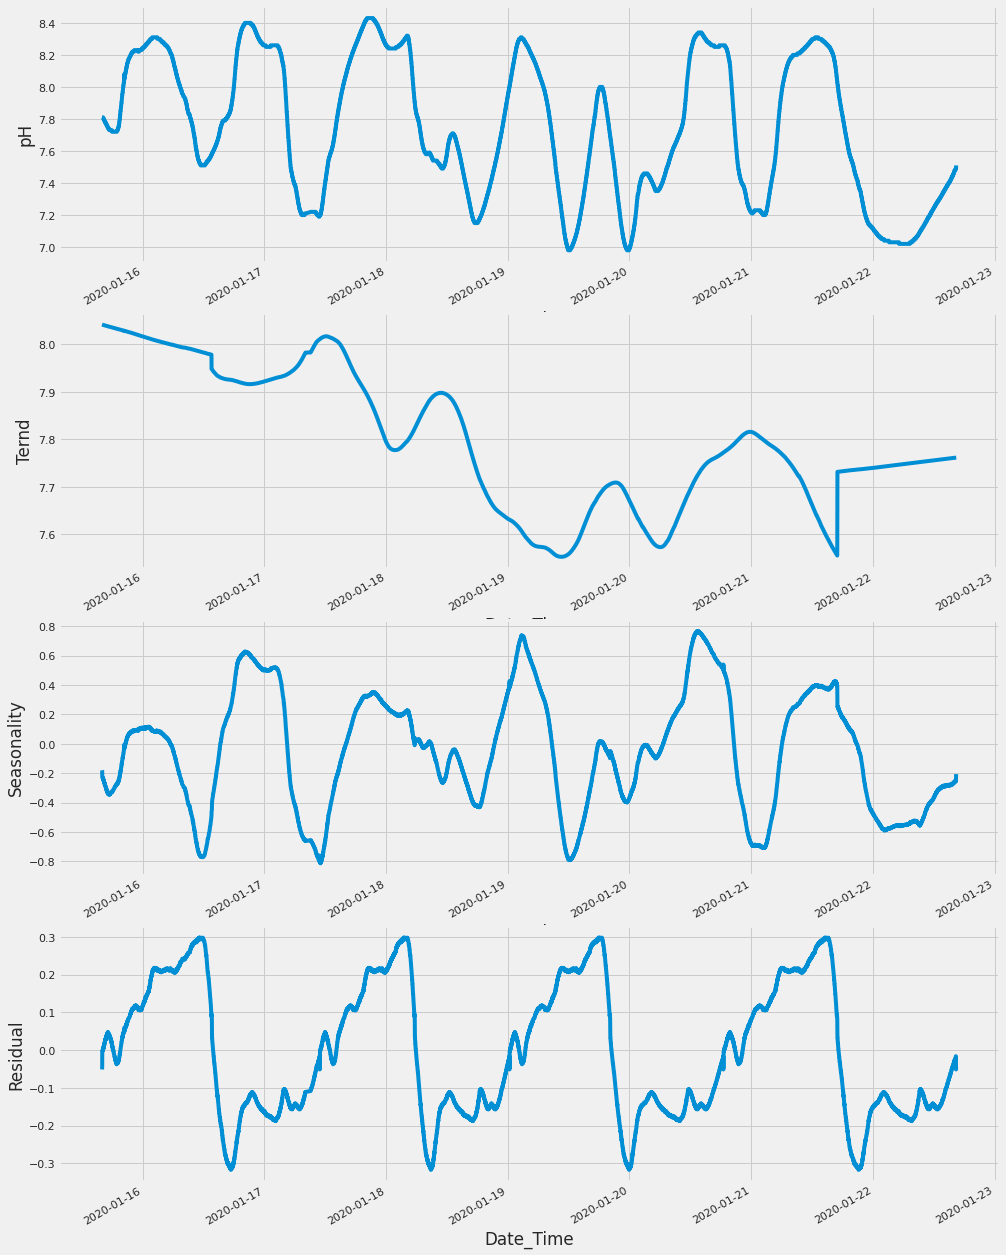

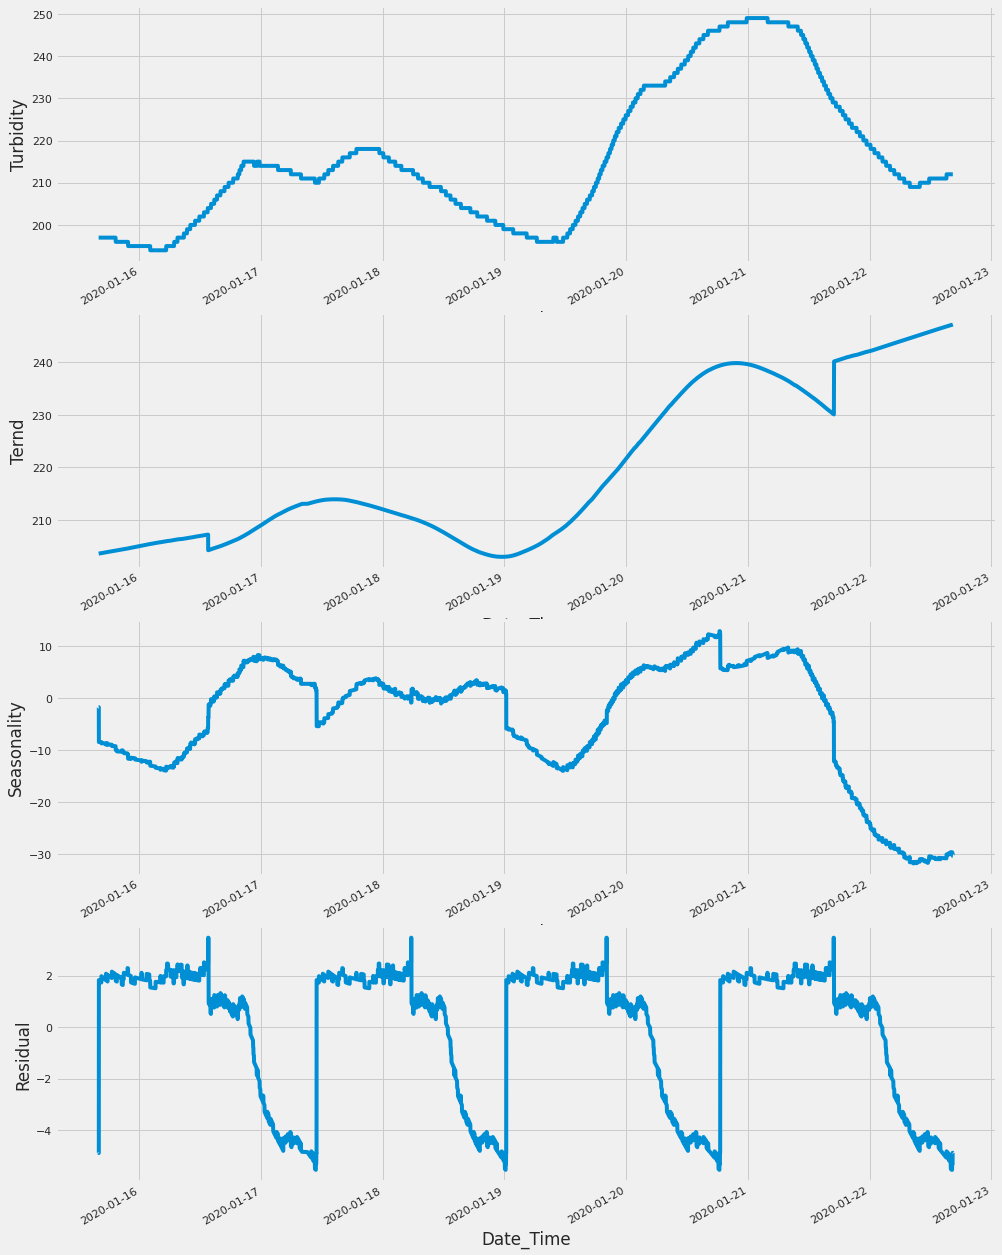

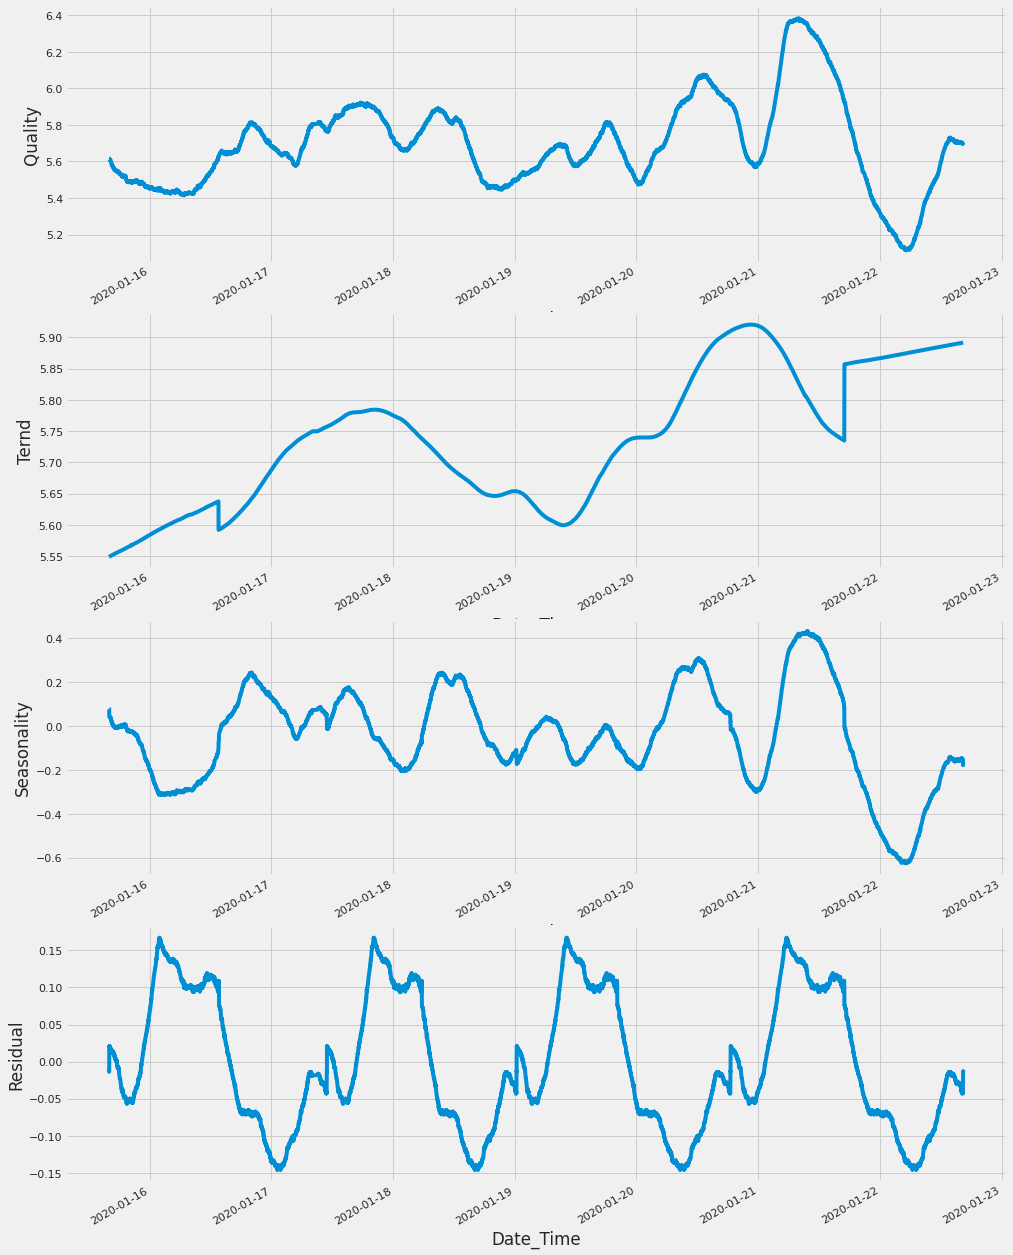

In [38]:
# Checking for trend, and seasonality
for head in headers:
    Checking_trend_seasonality(rawDataSens30,head)
   


<AxesSubplot:xlabel='Date_Time'>

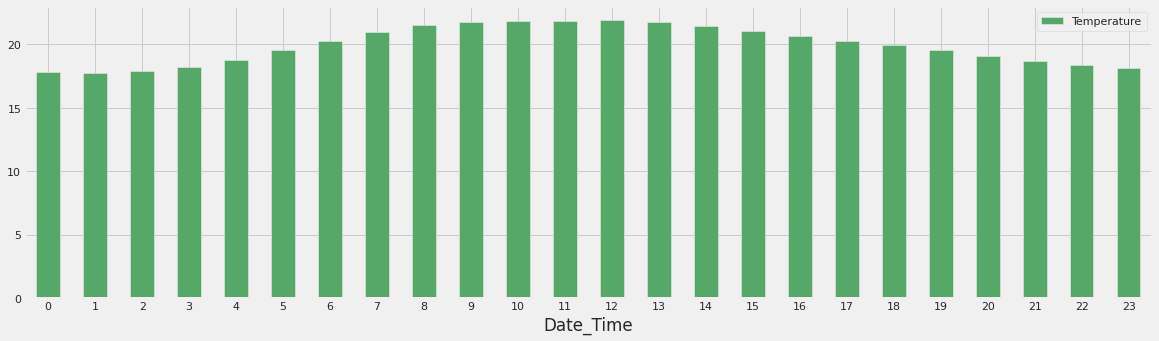

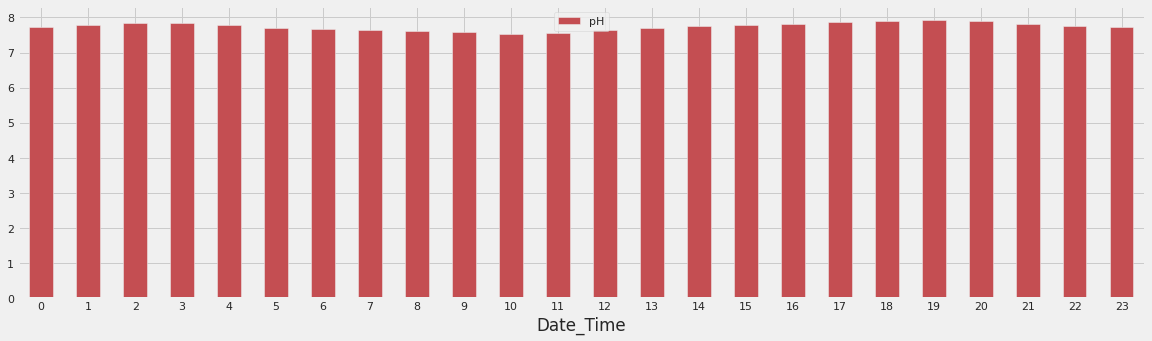

In [39]:
# The  Parameters of  Values per a day 
resampledData = downsample(rawDataSens30,60)
perHoure = resampledData.reset_index()
times = pd.to_datetime(perHoure.Date_Time)
dataTemperature = perHoure.groupby([times.dt.hour]).Temperature.mean()
datapH = perHoure.groupby([times.dt.hour]).pH.mean()
pd.DataFrame(dataTemperature).plot.bar(rot=0,color='g',figsize=(18,5))
pd.DataFrame(datapH).plot.bar(rot=0,color='r',figsize=(18,5))